<a href="https://colab.research.google.com/github/SanjanaS183/Vector-space-representation/blob/main/NLP_Assignment_2_distributional_semantics_Q_4%2C_5%2C6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Assignment 2 (40% of grade): Vector Space Semantics for Similarity between Eastenders Characters


In [ ]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('all')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction import DictVectorizer
from nltk.util import ngrams
%matplotlib inline
pd.options.display.max_colwidth=500
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from scipy.sparse import csr_matrix
from nltk import ngrams, pos_tag
import copy


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

In [ ]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
all_train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
all_train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE


In [ ]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
from random import shuffle, seed

seed(0) # set a seed for reproducibility so same split is used each time

episode_scene_column = all_train_data.Episode.astype(str) + "-" + all_train_data.Scene.astype(str)
all_train_data['episode_scene'] = episode_scene_column
episode_scenes = sorted(list(set([x for x in episode_scene_column.values]))) # need to sort to ensure same initial order

shuffle(episode_scenes)

print(len(episode_scenes))
episode_split = int(0.9*len(episode_scenes))
training_ep_scenes = episode_scenes[:episode_split]
test_ep_scenes = episode_scenes[episode_split:]
print(len(training_ep_scenes), len(test_ep_scenes))

def train_or_heldout_eps(val):
    if val in training_ep_scenes:
        return "training"
    return "heldout"

all_train_data['train_heldout'] = all_train_data['episode_scene'].apply(train_or_heldout_eps)

1394
1254 140


In [ ]:
episode_scene_column1 = test_data.Episode.astype(str) + "-" + test_data.Scene.astype(str)
test_data['episode_scene'] = episode_scene_column1

In [ ]:
print('Raw Data: ',np.shape(all_train_data))
train_data = all_train_data[all_train_data['train_heldout']=='training']
val_data = all_train_data[all_train_data['train_heldout']=='heldout']
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

Raw Data:  (15319, 8)
Train set:  (13638, 8)
Validation set:  (1681, 8)


In [ ]:
train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE,1350-1,training
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE,1350-1,training
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE,1350-2,training
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE,1350-2,training
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE,1350-2,training
...,...,...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE,1399-55,training
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE,1399-55,training
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE,1399-55,training
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE,1399-55,training


# Q4. Add dialogue context and scene features (20 marks)

In [ ]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    episode_scene1 = {}
    character_line_count = {}
    for line, name, scene in zip(df.Line, df.Character_name, df.episode_scene):
        if not name in character_docs.keys():
            
            episode_scene1[name] = {}
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        episode_scene1[name][scene] = True
        character_docs[name] += str(line)   + " _EOL_ "  # adding an end-of-line token
        character_line_count[name]+=1
  
    print("lines per character", character_line_count)
    print(character_docs)
    print(episode_scene1)
    return character_docs, episode_scene1



In [ ]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs, train_scene_info = create_character_document_from_dataframe(train_data,max_line_count = 360)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 342, 'CLARE': 352}
{'SHIRLEY': 'Look at ya, not a mark on ya. And you think you\'re an unlucky man. _EOL_ I\'m gonna get help. Oh where\'s my phone? Oh Kevin. Kevin you smashed it, didn\'t ya? Kevin, Kevin, where\'s your phone? _EOL_ No you\'re not, ssh, shut up. _EOL_ Fire brigade and ambulance. There\'s been an accident. On an industrial estate in Walford. ...Um, the Marsh Lane industrial estate. Please come quick. My husband- he\'s not my husband- my friend. He\'s trapped in the car. Please come quick... Shirley Carter. 82 82B George Street, Walford, E20. Please hurry, please come quick. _EOL_ Kevin. Kevin! _EOL_ Kevin I\'m gonna go to the main road - _EOL_ To make sure they know where to go. _EOL_ Kevin I\'ll be five minutes. _EOL_ You\'ll be fine. You\'re ta

In [ ]:
# preprocessing techniques which can be turned off and on:
preprocessing_switches = {
        "convert_usernames" : True,
        "separate_out_punctuation" : True,
        "convert_number_words_to_digits": True,
        "convert_numbers" : True,
        "remove_punctuation" : True,
        "convert_to_lowercase" : True,
        "remove_stopwords" : True,
        "apply_lemmatization" : True
    }

In [ ]:
# different pre-processing techniques which get called altogether by pre_process

# method to deal with number words being normalized to digits 
# taken from https://github.com/ShailChoksi/text2digits
def text2int(textnum, numwords={}):
    if not numwords:
        units = [
        "zero", "one", "two", "three", "four", "five", "six", "seven", "eight",
        "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen",
        "sixteen", "seventeen", "eighteen", "nineteen",
        ]

        tens = ["", "", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety"]

        scales = ["hundred", "thousand", "million", "billion", "trillion"]

        numwords["and"] = (1, 0)
        for idx, word in enumerate(units):  numwords[word] = (1, idx)
        for idx, word in enumerate(tens):       numwords[word] = (1, idx * 10)
        for idx, word in enumerate(scales): numwords[word] = (10 ** (idx * 3 or 2), 0)

    ordinal_words = {'first':1, 'second':2, 'third':3, 'fifth':5, 'eighth':8, 'ninth':9, 'twelfth':12}
    ordinal_endings = [('ieth', 'y'), ('th', '')]

    textnum = textnum.replace('-', ' ')

    current = result = 0
    curstring = ""
    onnumber = False
    for word in textnum.split():
        if word in ordinal_words:
            scale, increment = (1, ordinal_words[word])
            current = current * scale + increment
            if scale > 100:
                result += current
                current = 0
            onnumber = True
        else:
            for ending, replacement in ordinal_endings:
                if word.endswith(ending):
                    word = "%s%s" % (word[:-len(ending)], replacement)

            if word not in numwords:
                if onnumber:
                    curstring += repr(result + current) + " "
                curstring += word + " "
                result = current = 0
                onnumber = False
            else:
                scale, increment = numwords[word]

                current = current * scale + increment
                if scale > 100:
                    result += current
                    current = 0
                onnumber = True

    if onnumber:
        curstring += repr(result + current)

    return curstring

def tokenize_text(text):
    if preprocessing_switches["separate_out_punctuation"]:
        text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text) # separates punctuation at ends of strings
        text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text) # separates punctuation at beginning of strings
    if preprocessing_switches["convert_numbers"]:
        text = re.sub('\d+', 'NUMBER',text)
    # print("tokenising:", text) # uncomment for debugging
    tokens = text.split()
    return tokens

def remove_characters_after_tokenization(tokens):
    # note preserving critical social media/twitter characters @ and #
    p = '[{}]'.format(re.escape(string.punctuation)+'\…').replace("@", "").replace("\#", "")
    #print(p)
    pattern = re.compile(p)
    filtered_tokens = [f for f in filter(None, [pattern.sub('', token) for token in tokens])]
    return filtered_tokens

def convert_to_lowercase(tokens):
    return [token.lower() for token in tokens if token.isalpha()]

def remove_stopwords(tokens):
    stopword_list = nltk.corpus.stopwords.words('english')
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    return filtered_tokens

def apply_lemmatization(tokens, wnl=WordNetLemmatizer()):   
    return [wnl.lemmatize(token) for token in tokens]

def pre_process(text):
    """ Technique which will apply the techniques if they are set to 
    True in the global dict ::preprocessing_switches::
    """
    if preprocessing_switches["convert_usernames"]:
        text = re.sub("@[a-zA-Z0-9:.]+", "@username", text)
    if preprocessing_switches["convert_number_words_to_digits"]:
        text = text2int(text)
    global tokens 
    tokens = tokenize_text(text)
    if preprocessing_switches["remove_punctuation"]:
        tokens = remove_characters_after_tokenization(tokens)
    if preprocessing_switches["convert_to_lowercase"]:
        tokens = convert_to_lowercase(tokens)
    if preprocessing_switches["remove_stopwords"]:
        tokens = remove_stopwords(tokens)
    if preprocessing_switches["apply_lemmatization"]:
        tokens = apply_lemmatization(tokens)
    return tokens



In [ ]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

In [ ]:
def to_feature_vector_dictionary(character_doc, scene, extra_features = []):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
  
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
  
    counts = Counter(character_doc)  # for now a simple count
    #counts = dict(counts)
    
    # Extract bigrams
    _N_ =1
    for n in range(1,_N_+1):
        new_tokens = ["<s>"]*(n-1) + tokens + ["</s>"]
        for i in range(n-1, len(new_tokens)):
            
            raw_ngram = " ".join(new_tokens[i-(n-1):i+1])
            n_gram = "{}@{}".format(n, raw_ngram)

            counts[n_gram]+=1
    counts.update(scene)
    
    return counts





# Q5. Improve the vectorization method (20 marks)

In [ ]:
corpusVectorizer = DictVectorizer()
TfidfTransformer1 = TfidfTransformer(norm = 'l2' ,smooth_idf = False , sublinear_tf = True, use_idf = True)


def create_document_matrix_from_corpus(corpus, scene, fitting=False):
    '''Method which fits different vectorizers
    on data and returns a matrix.

    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)'''
    
    # uses the global variable of the corpus Vectorizer to improve things


    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc, scene[name]) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc, scene[name]) for name, doc in corpus])
    if fitting:
        TfidfTransformer1.fit(doc_feature_matrix)
    doc_feature_matrix = TfidfTransformer1.transform(doc_feature_matrix)
   
    
    return doc_feature_matrix

training_feature_matrix= create_document_matrix_from_corpus(training_corpus,train_scene_info,fitting=True )

In [ ]:
training_feature_matrix

<16x5096 sparse matrix of type '<class 'numpy.float64'>'
	with 22376 stored elements in Compressed Sparse Row format>

In [ ]:
# get the validation data- only 40 lines used for each character
val_character_docs, val_scene_info = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'TANYA': 40, 'MAX': 40, 'SEAN': 35, 'SHIRLEY': 40, 'OTHER': 40, 'STACEY': 40, 'RONNIE': 40, 'JACK': 40, 'PHIL': 40, 'IAN': 40, 'JANE': 40, 'ROXY': 40, 'HEATHER': 40, 'MINTY': 40, 'CHRISTIAN': 40, 'CLARE': 40}
{'TANYA': "Who's that? _EOL_ No no no leave it, leave it. He ain't got a key. He'll go away. Do you want some crisps? _EOL_ I told you to ignore it. _EOL_ Just go away will you, Max. _EOL_ He's a friend. _EOL_ There's no point. _EOL_ What you doing home? _EOL_ Yeah. _EOL_ You should have told me. _EOL_ Look I'm... _EOL_ Abi... _EOL_ Oscar okay? Good. Thanks for feeding the girls Dot. I won't be long, I promise. Ben! Can you move it please? Got better things to do! _EOL_ It's about his Doctor Who whatsits. Got a bit upset. _EOL_ Why don't I just pop up... _EOL_ Wanted to apologise to Ben about washing his cards. He can get himself some more. _EOL_ Alright Peggy, don't get your knickers in a twist. Oops. _EOL_ Yeah, ain't got me sea legs. _EOL_ Told you, I came 

In [ ]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, val_scene_info, fitting=False)

In [ ]:
val_feature_matrix

<16x5096 sparse matrix of type '<class 'numpy.float64'>'
	with 3337 stored elements in Compressed Sparse Row format>

In [ ]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [ ]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [ ]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [ ]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 1.1875
mean cosine similarity 0.31526595569150784
14 correct out of 16 / accuracy: 0.875


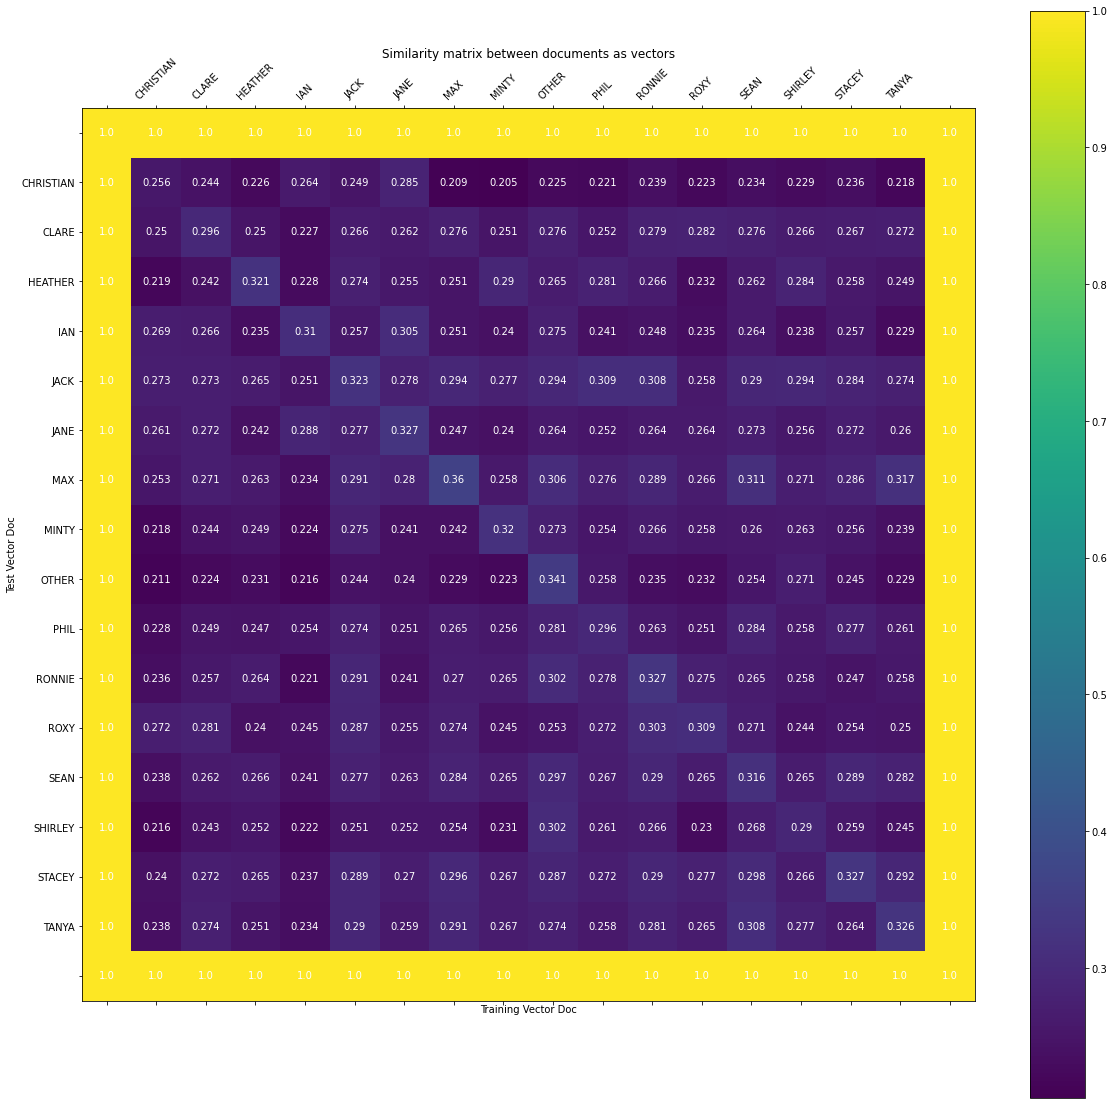

In [ ]:
plot_heat_map_similarity(df)

# Q6. Run on final test data  (10 marks)


In [ ]:
# redo on all training data with the first 400 character lines used
train_character_docs, train_scene_info = create_character_document_from_dataframe(all_train_data, max_line_count=400)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer()
TfidfTransformer1 = TfidfTransformer(norm = 'l2' ,smooth_idf = False , sublinear_tf = True, use_idf = True)
training_feature_matrix = create_document_matrix_from_corpus(training_corpus, train_scene_info,fitting=True)

# get the test data using 40 lines per character
test_character_docs, test_scene_info = create_character_document_from_dataframe(test_data, max_line_count=40)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
test_corpus = [(name, pre_process(doc)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, test_scene_info,fitting=False)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

lines per character {'SHIRLEY': 400, 'OTHER': 400, 'JACK': 400, 'RONNIE': 400, 'TANYA': 400, 'SEAN': 400, 'ROXY': 400, 'HEATHER': 400, 'MAX': 400, 'IAN': 400, 'JANE': 400, 'STACEY': 400, 'PHIL': 400, 'MINTY': 400, 'CHRISTIAN': 385, 'CLARE': 400}
{'SHIRLEY': 'Look at ya, not a mark on ya. And you think you\'re an unlucky man. _EOL_ I\'m gonna get help. Oh where\'s my phone? Oh Kevin. Kevin you smashed it, didn\'t ya? Kevin, Kevin, where\'s your phone? _EOL_ No you\'re not, ssh, shut up. _EOL_ Fire brigade and ambulance. There\'s been an accident. On an industrial estate in Walford. ...Um, the Marsh Lane industrial estate. Please come quick. My husband- he\'s not my husband- my friend. He\'s trapped in the car. Please come quick... Shirley Carter. 82 82B George Street, Walford, E20. Please hurry, please come quick. _EOL_ Kevin. Kevin! _EOL_ Kevin I\'m gonna go to the main road - _EOL_ To make sure they know where to go. _EOL_ Kevin I\'ll be five minutes. _EOL_ You\'ll be fine. You\'re ta